# Nutritional reverse engineering
_Tracing nutrient composition back to food product categories_

_"Show me your nutrients, and I'll tell you who you are"_

## Motivation

The development of the *Open Food Facts* project in 2012 was seen as a major win for enhancing consumer awareness and challenging food producers to focus on the nutritional value of their products. The collaborative database has attracted increased attention during the past couple of years due to its collaboration with the French government on the development and promotion of a nutritional rating system as part of the *Nutri-Score* brand. Calculated directly on the nutrient content of food products in a way inspired by the nutrient profiling system of the British Food Standards Agency, *Nutri-Score* was introduced in 2016 and its popularity has led Belgium and Spain to adopt it as well.

With the database emerging as a *"Wikipedia of food products"*, the issue of data quality has been brought into focus. As a collaborative database whose size makes it hard to moderate, *Open Food Facts* is expectedly subject to a series of inconsistencies, including inaccurate product submissions, data entry mistakes and missing data. It is a major issue, since data quality is crucial for allowing any kind of systematic use of the database, such as calculating nutritional ratings or supporting food-related analysis. While the data problems with the nutritional information itself are expected to be controlled by incorporating government-provided information into the database, issues with other fields might not have such obvious solutions.

In this part of our project, we focus on the product category tree of the database. Product categories provide a popular level of granularity when analysing food products, such as when articulating dietary guidelines, suggesting healthier substitutes, exploring trends in certain kinds of food or connecting nutritional information to food production standards and shopper insights. For *Open Food Facts*, product categories are particularly important, both because of the open nature of the database (which encourages a brand-agnostic view of the products) and because of its utilization in calculating or validating nutritional ratings (with the nutritional profiling system behind the calculations involving category-specific computations).

The *Open Food Facts* database does have a product category tree, with each product being assigned to a series of categories and subcategories. However, as we can see in our data exploration notebook,  a considerable number of products are not properly classified, while nearly three fourths of the database is not assigned to any category at all. This unfortunately renders the current category tree ill suited for related analyses.

How can we overcome this problem? Is there some other way we could validate existing classifications or impute missing ones? A quick valid answer would point to the textual information about the product, particularly its title. Although not yet explored in the context of the *Open Food Facts* project, using text classification to group together products that share words in their title is indeed a popular product classification technique in both scientific literature and practical applications. Still, this method, in our specific context, is subject to limitations, as it might *a)* group together products that are similar text-wise but actually different (e.g. "cream sauce" and "ice cream"), *b)* miss connections between similar food products that are quite differently named (e.g. "Beef sausages with tomato" and "Black pudding"), and *c)* lead to nutritionally irrelevant categorizations which might be of interest in *Open Food Facts*-related projects (e.g. not discriminating between low-fat and full-fat yoghurt).

As part of our project, we investigate another piece of information that might provide a hint about the category of a product, particularly its nutritional composition. We make the hypothesis that products of the same category share strong similarities in their nutrient content, but are also very different from products of other categories. If this hypothesis stands, then we should be able to group products based on their nutrition facts so that the groups provide a hint about the category.

The goal of our analysis is to evaluate our hypothesis about category inner homogeneity and cross-category divergence in terms of nutritional composition, and assess whether nutrient content can serve as a discriminating factor when attempting to infer product categories.

Practically this is an unsupervised learning problem, as we have to discover the categories ourselves. We will use clustering to group products based on their nutritional composition, and then examine if the resulting clusters provide any hints about possible categorization opportunities.

Let's get started!

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
from os.path import join

# Project specific module/functions
from healthy_candies.load import load_data
from healthy_candies.utils import plot_settings
from healthy_candies.path import STATIC_DATA_FOLDER

# Machine learning
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot settings
sns.set()  # Use default seaborn styling for all plots
sns.set_context('notebook')
plt.rcParams['figure.dpi'] = 100

## Preprocessing

In [3]:
# Load data
data = load_data(limit_have_nutri_score=False)

# Identify nutrition facts columns
cols = data.columns
nf_cols = cols[cols.str.contains(r'100g')] \
    .drop(['nutrition-score-fr_100g', 'nutrition-score-uk_100g'])

We will use the nutrition fact columns, each of which refers to a single nutrition fact (e.g. energy, proteins, sodium). All nutrients are measured in grams (g), except for energy, which is measured in kilojoules (kJ).

Nutritional information is provided per 100g/ml, which leads us to our first need for a decision. At this level, products are not directly comparable nutrition-wise, as the amount we consume at a time is different for each product. For example, we would probably eat 200 grams of yoghurt, while it would be only 1 gram of salt; these two products are very different in terms of *serving size*.

Here, we could choose either to convert our quantities according to serving size, or merely consider nutrients at the 100g/ml level. Intuitively, we do expect serving size to be similar for products in the same category, so not doing the conversion might seem useful in our attempt to discriminate between categories. However, our goal is to explore the possibility of drawing inferences from the nutritional value itself, so it would be in our best interest to control for serving size when we do that.

Moreover, incorporating serving size in our analysis can be beneficial from a technical perspective. It can help our model discriminate between products that happen to be very similar at the 100g/ml level, but are very different nutritionally as they are normally consumed in different quantities. For instance, pasta sauce and mustard sauce both deliver around 250 kJ per 100g. According to the official serving size for each product, we would consume 125 grams of pasta sauce (= 300 kJ) at a time; still, the respective amount for mustard would be 5 grams and 13 kJ! Apart from that, converting to serving-size quantities provides us with an additional, contextually relevant layer in our feature normalization process. It also balances somewhat the density of the different clusters, which is particularly important for the effectiveness of the DBSCAN algorithm we will use later.

In [4]:
# Work with data for which serving size is known
data_ss = data[data.serving_size.notnull()].copy()

# Regex pattern to match quantities
regex = '((?:[0-9]+[,\.])?[0-9]+)\s*' \
        '(g|ml|cl|l\b|fl oz|oz|mg)'

# Extract quantity info
data_ss[['quantity', 'measure_unit']] = data_ss.serving_size \
    .str.lower() \
    .str.extract(regex)

# Convert quantities to g/ml
quantity_conversions = {
    'g': 1,
    'oz': 28.3495,
    'mg': 0.001,
    'ml': 1,
    'cl': 10,
    'l': 1000,
    'fl oz': 29.5735}

# Fix decimal separator issues
q = data_ss.quantity.str.replace(',', '.').astype(float)

# Convert quantities
c = data_ss.measure_unit.dropna().apply(lambda m: quantity_conversions[m])
data_ss['quantity_converted'] = q.multiply(c)

for col in nf_cols:
    data_ss.loc[:, '{}_conv'.format(col)] = \
        data_ss['quantity_converted']/100*data_ss[col]

nf_cols_conv = nf_cols + '_conv'

We continue with $241\,840$ out of the $708\,013$ products ($\approx 34\%$) originally in the database. The table below displays the percentage of available data for each nutrient that are included in this sample. As shown, for, say, the 15 best represented nutrients, we are working with at least $40\%$ of the available data.

In [5]:
# Calculate 15 nutrients with most available data
pop_nf_cols = nf_cols[nf_cols.isin(data[nf_cols].count()
                                   .sort_values(ascending=False)
                                   .head(15).index)]
# Find proportion of available data included in the sample
# for each of the 15 nutrients
(data_ss[pop_nf_cols].count()/data[pop_nf_cols].count()).round(2)

energy_100g           0.40
fat_100g              0.40
saturated-fat_100g    0.37
trans-fat_100g        1.00
cholesterol_100g      1.00
carbohydrates_100g    0.40
sugars_100g           0.39
fiber_100g            0.67
proteins_100g         0.40
salt_100g             0.41
sodium_100g           0.41
vitamin-a_100g        1.00
vitamin-c_100g        0.99
calcium_100g          0.99
iron_100g             0.99
dtype: float64

It is here that we should consider what a missing value really means in the context of our dataset. We can guess that a contributor might have skipped filling in the nutrients or the OCR failed to detect them from the scan that they provided, or they might have not been provided for the product in the first place.

However, it could also mean that they had a zero value, which also raises some questions about the non-missing zero values as well. A need for a design decision that emerges from this is whether we should consider zero as a missing value or not. Zero can be a valid nutrient value for a lot of products (e.g. water has zero calories). On the other hand, we can easily imagine a scenario where a user fills in zero values for missing nutrient information during the product submission.

The truth seems to be lying somewhere in the middle, with zeros used both indicating an actual zero value and indicating a missing value; actual zero values sometimes are not filled in at all, ending up as missing values. In the context of this project, we are not qualified to make a reliable distinction between the two; therefore we will consider missing values as missing values, and zero values as actual zero values.

In the following slice of our dataset, all of the products listed with zero energy value actually correspond to products with zero energy value. This indicates that our decision might be a safer bet than making additional assumptions.

In [6]:
data_ss[data_ss.energy_100g == 0].product_name.head(10)

108                                  Naturablue original
440    Naturally Flavored Beverage Enhancer With Othe...
538                                 Chamomile Herbal Tea
539                               Herbal Tea, Peppermint
540                                   Linden Flowers Tea
542                                 Apple & Cinnamon Tea
543                                            Green Tea
544                               Shave Grass Herbal Tea
545                         Herbal Tea, Chamomile * Mint
546                                 Artichoke Herbal Tea
Name: product_name, dtype: object

Having decided that we will consider as missing the values that are originally indicated as missing, we now have to decide how we will handle them in our model.

Let's first explore the sparsity of the features. We have over $100$ nutrients in our dataset, but, as shown below, we observe an overwhelming number of missing values for most of them.

In [7]:
# Available data for each feature
print('Number of features: {}'.format(len(nf_cols_conv)))

nf_cols_percent_available = data_ss[nf_cols_conv].count() / len(data_ss)
print('Percentage of available data for each feature')
display(nf_cols_percent_available.sort_values(ascending=False).head(20))

Number of features: 103
Percentage of available data for each feature


energy_100g_conv                 0.984724
fat_100g_conv                    0.983099
carbohydrates_100g_conv          0.982991
proteins_100g_conv               0.980272
salt_100g_conv                   0.975970
sodium_100g_conv                 0.975854
sugars_100g_conv                 0.932753
saturated-fat_100g_conv          0.870461
fiber_100g_conv                  0.760475
cholesterol_100g_conv            0.599731
trans-fat_100g_conv              0.597366
calcium_100g_conv                0.586663
iron_100g_conv                   0.585270
vitamin-c_100g_conv              0.584979
vitamin-a_100g_conv              0.572725
potassium_100g_conv              0.103061
polyunsaturated-fat_100g_conv    0.093068
monounsaturated-fat_100g_conv    0.093018
vitamin-pp_100g_conv             0.049157
vitamin-b1_100g_conv             0.047004
dtype: float64

We will necessarily have to discard nutrients with $50\%$ or less available data, which would not be able to provide much information to our model. However, we will work with all of the 15 remaining features, as we think they will add to the expressive power of our model.

In [8]:
# Consider features available for at least 50% of the products
nf_cols_pruned = nf_cols_conv[nf_cols_percent_available > 0.5]

for t in range(8, 16, 1):
    print('{} products have fully available data for at least'
          ' {} of the 15 nutrients.'
          .format(len(data_ss[data_ss[nf_cols_pruned].count(axis=1) >= t]), t))

217240 products have fully available data for at least 8 of the 15 nutrients.
192091 products have fully available data for at least 9 of the 15 nutrients.
148302 products have fully available data for at least 10 of the 15 nutrients.
142271 products have fully available data for at least 11 of the 15 nutrients.
136745 products have fully available data for at least 12 of the 15 nutrients.
134246 products have fully available data for at least 13 of the 15 nutrients.
131111 products have fully available data for at least 14 of the 15 nutrients.
126468 products have fully available data for at least 15 of the 15 nutrients.


Another challenge that immediately follows regards the missing data. We can safely drop products where information is missing for all of the nutrients, but what about the rest?

A strategy followed in such cases is imputation, replacement of the missing data by substituted values. An important problem with imputation is that it can create a lot of noise and limit the validity of the results. Especially in our case, where there is a large variance in nutrients between products, this additional noise should be avoided.

As we wish to keep as many features in the model as possible, we will necessarily have to drop products. In the figure above, we try to identify a subset of the 15 features with as few missing data as possible. We have already discussed that 8 or 9 features might not represent the nutritional composition of the products effectively; the difference between the number of products that have nutrient information for at least 10 nutrients and the respective number for 15 nutrients is very small; therefore we will use only products with fully available data for all 15 nutrients.

In [9]:
data_ss.dropna(subset=nf_cols_pruned, inplace=True)

As such, we conclude our cleaning process with a final sample of $126\,467$ products, $\approx 18\%$ of our initial dataset. Although still quite a large sample on its own, it is only a small fraction of what we had in the beginning. Because of the large numbers of missing values in most of the columns, it is not easy to get an idea of its representativeness. However, we can still get some hints.

For example, the following kernel density estimation plot reveals that the distribution of the nutritional rating is similar between the original dataset and our sample. This is particularly important, as it ensures that we have an appropriate representation of products from different parts of the nutritional value spectrum.

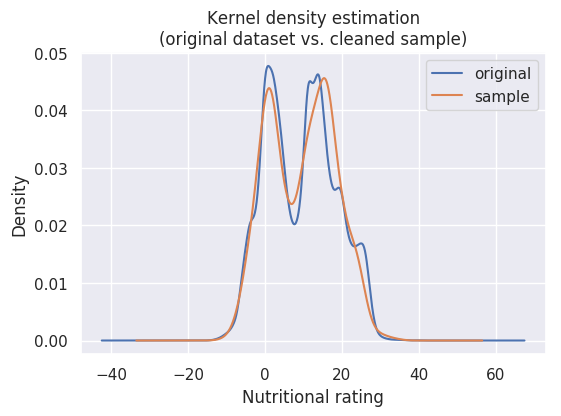

In [10]:
data['nutrition-score-fr_100g'].dropna().plot.kde(label="original")
data_ss['nutrition-score-fr_100g'].dropna().plot.kde(label="sample")
plt.legend()
plot_settings({
    'title': 'Kernel density estimation\n'
    '(original dataset vs. cleaned sample)',
    'xlabel': 'Nutritional rating'})

Furthermore, even if, as we have seen before, the category fields are extremely inconsistent, we can still observe similarities between the original dataset and the cleaned sample when we check the distribution of the most frequent product categories.

In [11]:
def compute_main_category_distribution(data: pd.DataFrame) -> pd.DataFrame:
    return (
        data
        .groupby('main_category_en')
        .count()
        [['code']]
        .rename(columns={'code': '% of products '})
        / len(data.dropna(subset=['main_category_en']))
    ).round(3) * 100


pd.merge(
    compute_main_category_distribution(data),
    compute_main_category_distribution(data_ss),
    suffixes=('(original)', '(cleaned)'),
    on='main_category_en'
).reset_index().sort_values('% of products (cleaned)', ascending=False).head(10)

,main_category_en,% of products (original),% of products (cleaned)
137,Plant-based foods and beverages,21.3,23.1
176,Sugary snacks,14.0,18.1
95,Groceries,5.4,15.2
16,Beverages,14.5,7.8
60,Dairies,8.9,6.3
156,Salty snacks,1.7,2.5
127,Pains-bagel,0.0,2.1
82,Fruit juices,1.7,2.0
118,Meats,5.4,1.4
116,Meals,4.6,1.2


We acknowledge the relative size of the final cleaned sample as a limitation of this analysis as a result of the missing data. However, as the goal of this analysis is to provide the basis for more extensive future work, we expect that the plans of the *Open Food Facts* project to retrieve complete nutritional information from other sources will also make possible the reproduction of our analysis with a much larger subsample.

In our model, we will not consider the feature `salt_100g_conv`, as it is directly connected to `sodium_100g_conv`.

As a final step before training our model, we also scale the data based on the interquartile range so that the scaling is not influenced by outliers. We do not remove outliers based on the standardized values, because DBSCAN (which we will be using as our clustering algorithm) is particularly robust to noise.

In [12]:
# Do not consider `salt` information
nf_cols_ml = nf_cols_pruned.drop('salt_100g_conv')

# Reset dataframe index so as to be able to track products in the numpy
# arrays
data_ss.reset_index(inplace=True)
data_ml = data_ss[nf_cols_ml].values

# Provisionally scale data based on interquartile range to
# ensure robustness
scaler = RobustScaler()
data_ml_scaled = scaler.fit_transform(data_ml)

## Model

We have formulated our problem as a clustering task: we attempt to group products based on their nutritional content so that each group can be interpreted in terms of a specific category.

We opt for DBSCAN as our clustering method, for the following reasons:

* It can scale to a large dataset. We are developing an artefact that needs to be able to handle the whole *Open Food Facts* database - currently at 700K records, but with a possibility of exploding volume-wise as a result of its growing popularity and international appeal. This eliminates alternatives, such as traditional hierarchical clustering approaches or the mean-shift algorithm,
* We are expecting a non-flat division of the feature space rather than convex shapes, because of the subtle differences in nutritional categories in similar categories, such as yoghurt and cottage cheese. On this front, a density-based approach is much more suitable than the also scalable k-means algorithm,
* It handles noise well and is robust to outliers, which is particularly important here because of the inconsistencies in the original dataset, as explained previously. DBSCAN usually leads to better defined clusters, only extracting truly dense structures from the data.

To interpret the resulting clusters, we will use the `product_name` information about its products, as other possibly useful fields, such as `generic_name`, `categories` and `origins`, contain an excessive number of missing values. 

### Parameter selection

As we have discussed in the lectures, DBSCAN requires two parameters to be specified before training: `epsilon` (the maximum distance at which a data point can *directly* reach a neighbour) and `minPts` (the minimum number of directly reachable neighbours a data point must have in order to be considered part of a cluster). The selection of the parameters is of critical importance, as it highly influences the results of the algorithm.

#### Choosing the distance measure

Our estimation of the two parameters depends highly on the distance measure we will use in the algorithm. We opt for the *Euclidean* distance based on the characteristics of our feature space. For example, it can't be *Manhattan*, as our features are continuous and neighbours can be reached directly at any direction; it can't be *cosine*, as we are interested in the magnitude of the distance vectors instead of the angle between them.

#### Choosing epsilon and minPts

So, how to choose the two parameters? In their initial presentation of the DBSCAN algorithm, Ester et al. [1] had proposed a simple heuristic that estimates `epsilon` based on the distances between points and their $k$-th nearest neighbours, where $k$ is equal to `minPts`. In that paper, they had suggested that setting $k$ to 4 is suitable for most datasets. However, because of the large number of inconsistencies in our case, we will follow their revised recommendations [2], choosing our $k$ as twice the number of features minus 1 and setting `minPts` to $k+1$.

We apply the heuristic as follows:

We set $k = 2 * 14 -1 = 27$, and calculate the distance between each point and its $k$-th nearest neighbour (called *$k$-dist* in the aforementioned papers).

In [13]:
k = 27

kth_nn_distances = NearestNeighbors(n_neighbors=k+1, metric='euclidean') \
  .fit(data_ml_scaled) \
  .kneighbors(data_ml_scaled)[0][:, k]

We sort the points in descending order of their $k$-dist values and plot their density distribution. Ester et al. [1] call this the *sorted $k$-dist graph*. We see that, for the first points, the line drops very steeply - here, in fact, the drop is so steep that we need a logarithmic scale on the *x* axis to make sense of the plot. 

We are trying to identify a *threshold point* where the line stops dropping steeply, forming a visual "valley" which corresponds to a "normal" range of $k$-dist values. This *threshold point* will be the `epsilon` of our model and will be one of the core points in the *thinnest* cluster that DBSCAN will product. From the left plot below, we see that the valley actually appears close to zero, despite the presence of much larger *$k$-dist* values in the dataset.

If we exclude the first part of the $k$-order where the drop is extremely steep (right plot), we can see that the valley appears to start somewhere just below $1$.

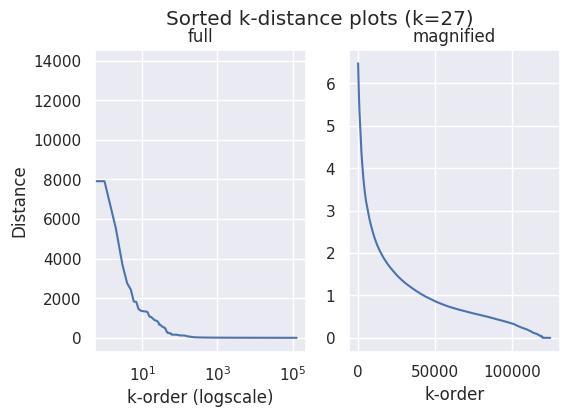

In [14]:
fig, ax = plt.subplots(1, 2)

# Full picture
f = ax[0]
f.semilogx(
    np.flip(np.sort(kth_nn_distances), axis=0))
f.set_ylabel('Distance')
f.set_xlabel('k-order (logscale)')
f.set_title('full')

# Zoomed into the interesting region
z = ax[1]
z.plot(
    np.flip(np.sort(kth_nn_distances), axis=0)[1500:])
z.set_xlabel('k-order')
z.set_title('magnified')

null = fig.suptitle('Sorted k-distance plots (k=27)')

It is already clear from the plot that, if we choose an `epsilon` value under $1$, we should expect that an extremely large number of points will be classified as noise. This is somewhat expected, considering the data inconsistencies we have already discussed. On the other hand, by increasing `epsilon` too much, we risk considering noise as core points, resulting in less well-defined clusters.

When trying to specify the exact values for the parameters, we should take into account the risk of getting a degenerate clustering result. As Schubert et al. [3] suggest, a degenerate result could be obtained either if the algorithm classified too many points as noise or if a single component contains an excessively large proportion of the dataset. They propose that a desirable amount of noise would be between 1% and 30%, while the largest component should contain no more than 20% to 50% of the clustered points.

We will use these guidelines to decide between different values of `epsilon`, as shown in the plot above.

In [15]:
# Avoiding sklearn DBSCAN complexity for the generation
# of the plots

# Get unique only records and how many times they appear
# on the dataset
data_ml_unique, sample_weight = \
    np.unique(data_ml_scaled, return_counts=True, axis=0)

# Compute the graph of neighbors for the maximum value of
# epsilon we want to examine
max_epsilon = 1
distance_matrix = NearestNeighbors(radius=max_epsilon) \
    .fit(data_ml_unique) \
    .radius_neighbors_graph(data_ml_unique, mode='distance')

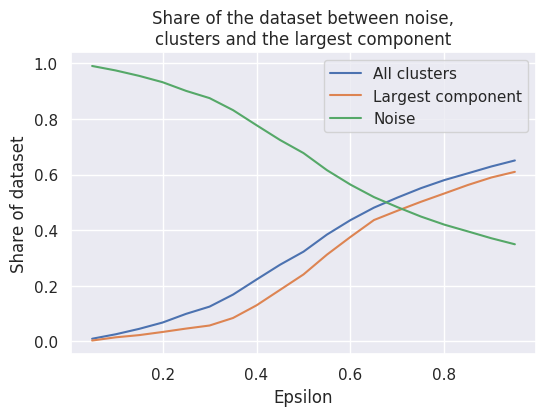

In [16]:
candidate_epsilons = np.arange(0.05, 1, 0.05)
clustered_p = []
noise_p = []
largest_p = []
for eps in candidate_epsilons:
    # Run DBSCAN on the precomputed distance matrix for efficiency reasons
    labels = DBSCAN(eps=eps, min_samples=28, metric='precomputed') \
        .fit(distance_matrix, sample_weight=sample_weight) \
        .labels_
    # Number of clustered points
    labels_clustered = labels[np.where(labels != -1)]
    # % of the dataset in clusters
    clustered_percentage = len(labels_clustered)/len(labels)
    clustered_p.append(clustered_percentage)
    # % of the dataset classified as noise
    noise_percentage = 1 - clustered_percentage
    noise_p.append(noise_percentage)
    # % of the dataset in the largest component
    largest_comp_percentage = np.max(np.bincount(labels_clustered))/len(labels)
    largest_p.append(largest_comp_percentage)

plt.title('Share of the dataset between noise,\n'
          'clusters and the largest component')
plt.plot(candidate_epsilons, clustered_p)
plt.plot(candidate_epsilons, largest_p)
plt.plot(candidate_epsilons, noise_p)
plt.xlabel('Epsilon')
plt.ylabel('Share of dataset')
null = plt.legend(['All clusters', 'Largest component', 'Noise'])

On the plot above, for `minPts`$=28$, we confirm that, when we select larger values of `epsilon`, the share of the points assigned to some cluster increases and the share of noise points decreases. The key here is the size of the largest component. Our plot differs from the ones in Schubert et al. [3], with the largest component growing at the same rate as the total clustered points: it seems that, for most of the points previously classified as noise, when they are considered as core points, they join the largest component instead of a smaller, more "specific" component. This indicates that the degree of degeneracy remains generally stable across different values of `epsilon`.

That said, we find our best option in the region of the graph where the line of total clustered points diverges most from the line of the largest component. There, the number of noise points is unavoidably large, but the largest component is still "pure" because of the small `epsilon` and the distribution of points among clusters is more even. According to this observation, we select `epsilon` $= 0.4$.

### Results

Using the sci-kit implementation of DBSCAN, we train our model for `epsilon` $=0.4$ and `minPts` $=28$.

In [17]:
# Fit the model
dbscan = DBSCAN(eps=0.4, min_samples=28, metric='euclidean')
dbscan.fit(data_ml_scaled)

# Bring the results to our dataframe
data_with_clusters = data_ss.join(
    pd.DataFrame(dbscan.labels_, columns=['label']),
    how='inner')

# Clustering descriptives
labels = data_with_clusters.label
total = len(labels)
clustered = len(labels[labels > -1])
largest_comp = np.max(np.bincount(labels[labels > -1]))

print("Number of clusters: {}".format(len(labels.unique())-1))
print("Number of clustered points: {} ({}%)"
      .format(clustered, np.round(clustered/total*100)))
print("Size of the largest component: {} ({}%)"
      .format(largest_comp, np.round(largest_comp/total*100)))

Number of clusters: 182
Number of clustered points: 39648 (31.0%)
Size of the largest component: 19917 (16.0%)


The fitting concludes with $182$ clusters, which contain $31\%$ of our total data. At nearly $70\%$, the number of points classified as noise by DBSCAN is expectedly large, consistent with our insights from the previous sections. However, the size of the largest component is reasonable, with the rest of the clusters still accounting for an appreciable share of the clustered points.

Below we can see the distribution of the clustered points among the different clusters:

In [18]:
grouped_by_label = data_with_clusters[labels > -1] \
    .groupby('label')

print("Distribution (%) of clustered points across clusters")
(grouped_by_label
 .count()
 .code
 .sort_values(ascending=False)
 .head(10)
 / clustered * 100) \
    .round(2)

Distribution (%) of clustered points across clusters


label
1     50.23
2      6.30
6      3.96
11     2.00
20     1.97
21     1.46
3      1.29
14     1.15
26     1.10
29     1.10
Name: code, dtype: float64

It is clear that the largest component, *Cluster 1*, includes a rather large proportion of the clustered points, which raises questions about how well-defined it is. However, the rest of the clusters look reasonably sized, and, because our `epsilon` value was relatively small, we expect data points included in them to share strong similarities in nutritional composition.

What do these clusters resemble? We had DBSCAN trained on nutrition facts, so it would be interesting what kind of nutritional composition products in each cluster have. Let's look at the first seven clusters:

In [19]:
grouped_by_label[nf_cols_ml] \
    .agg(['min', 'max']) \
    .round(3) \
    .head(7) \
    .style.background_gradient(cmap='summer')

Nutritional differences between the clusters are immediately visible. For instance, we can see how *Cluster 0* stands out from the others in terms of `energy` (kJ) per serving; we also learn that this amount of energy comes from the strong presence of `carbohydrates` rather than `fat`, which, along with a high value for `fiber` and a moderate one for `proteins` could possibly indicate that this cluster contains pasta or rice. As another example, in *Cluster 2*, we have larger quantities for `saturated_fat`, `cholesterol` and `proteins`, which could point either to meat products or dairy.

Note that, for most of the clusters, we get a minimum and a maximum value that - although normally very sensitive to noise - are pretty close. This indicates that our clusters might be quite dense. 

Of course, this is not a lucky guess game! It would be more interesting to look at what products these clusters contain. Let's take a peek at a random cluster, say, *Cluster 25*:

In [20]:
def generate_cluster_profile(label):
    print("PROFILING CLUSTER {}".format(label))
    c = data_with_clusters[labels == label]
    print("Size: {}".format(len(c)))
    print("\nAverage nutritional composition: ")
    print(c[nf_cols_ml].mean().round(3))
    print("\nProducts:")
    print(c.product_name.sample(20, random_state=0))


null = generate_cluster_profile(25)

PROFILING CLUSTER 25
Size: 174

Average nutritional composition: 
energy_100g_conv           408.747
fat_100g_conv                1.168
saturated-fat_100g_conv      0.706
trans-fat_100g_conv          0.000
cholesterol_100g_conv        0.007
carbohydrates_100g_conv     12.590
sugars_100g_conv            11.859
fiber_100g_conv              0.000
proteins_100g_conv           8.195
sodium_100g_conv             0.127
vitamin-a_100g_conv          0.000
vitamin-c_100g_conv          0.002
calcium_100g_conv            0.300
iron_100g_conv               0.000
dtype: float64

Products:
27436                         Good Day, Fat Free Milk
80711                                   Fat Free Milk
34443                           Select 1% Lowfat Milk
28288                                   Fat Free Milk
55679                                    Low Fat Milk
38715     Dairypure, Sweet Acidophilus 1% Lowfat Milk
1527                               Fat Free Skim Milk
94439                                   

When taking a random sample from the `product_name` column, we see that all of the records we get refer to low-fat milk products. The fact that *Cluster 25* is quite sizeable at $174$ products makes it all the more interesting.

Interestingly enough, none of these products had been assigned to a category in the original dataset!

In [21]:
len(data_with_clusters[labels == 174].categories_en.dropna())

0

When we see the full picture, we see that DBSCAN on nutritional information manages to group unclassified, in the original dataset, products into category-relevant clusters. Below we see that if we take the clusters with the smallest proportion of missing categories, we still see that, apart from clusters *124* and *177*, before the clustering we were missing category information for at least 80-90% of the points in each cluster!

In [22]:
l = grouped_by_label \
    .count()
l['% missing'] = (1 - l.categories_en / l.code) * 100
l[['code', '% missing']].sort_values(by="% missing").head(10)

,code,% missing
label,,
124,35,28.571429
177,31,38.709677
168,14,92.857143
165,29,93.103448
72,46,93.478261
145,35,94.285714
162,113,94.690265
73,105,95.238095
155,47,95.744681


Finally, let's get a picture of what category each cluster might represent by looking at product names inside each one.

In [23]:
data_with_clusters[labels > -1] \
    .groupby(['label', 'product_name']) \
    .count() \
    .sort_values(by=['label', 'index'], ascending=[True, False]) \
    .groupby('label').head(3)['code']

label  product_name                                 
0      Almond Granola                                     2
       Blueberry Pomegranate Crunch                       1
       Cascadian Farm Organic Oats And Honey Granola      1
1      Chicken Broth                                     63
       Tomato Ketchup                                    58
       Real Mayonnaise                                   44
2      Sharp Cheddar Cheese                              73
       Mild Cheddar Cheese                               51
       Mozzarella Cheese                                 49
3      Potato Chips                                      81
       Cooked Potato Chips                               17
       Potato Chips, Original                             9
4      Dried Cranberries                                 21
       Sweetened Dried Cranberries                        6
       Cranberries                                        4
5      Peanut Butter                           

To confirm whether these clusters do represent some category and which one, we can drill down into these clusters and see if there is some consistency among the products they contain. From the overview above, it becomes clear that some clusters are better defined (e.g. *0*: "granola", *2*: "cheddar cheese", *9*: "whole-grain bread", *175*: "fruit compote", *180*: "trail mix") than others (e.g. *5*: peanut butter also containing sunflower kernels). There are also cases of products of the same category that ended up in separate clusters. See, for example, clusters *7* and *60*, which both contain whole kernel corn.

In [24]:
data_with_clusters[labels.isin([7, 60])] \
    .groupby(['label', 'product_name']) \
    .count() \
    .sort_values(by=['label', 'index'], ascending=[True, False]) \
    .groupby('label').head(3)['code']

label  product_name                  
7      Whole Kernel Corn                 18
       Whole Kernel Golden Sweet Corn     7
       Organic Whole Kernel Corn          5
60     Cut Corn                           9
       Whole Kernel Golden Corn           6
       Whole Kernel Corn                  4
Name: code, dtype: int64

The number of such cases is relatively small, but their presence means that we needed a larger `epsilon` to get them included in the same core component. On the other hand, the degree of degeneracy would lead us toward smaller values of `epsilon` and `minPts` for the points included in the largest component. It becomes clear that the actual product categories might be very different from each other in terms of density, which is something we will discuss below.

The overall picture is, however, very encouraging.

## Discussion

What do these results tell us about the hypothesis we made in the beginning? We already intuitively knew that products of a category generally differ nutritionally from products of another. But what is the nature of this difference?

The fact that our DBSCAN model was able to extract, based on nutritional information only, clusters that represent actual product categories, indicates that products inside these clusters were similar enough to each other, but also very different from products in other categories. It is even more important that the resulting clusters were considerably dense, judging from the small `epsilon` we used and the considerably small range of values that every nutrition fact would take inside each cluster.

***Limitations.*** However, the amount of degeneracy - $69\%$ of our data points were classified as noise - possibly provides counter evidence to this hypothesis. For all those points, nutritional composition alone was not enough to distinguish between different categories. In addition, as we discussed above, the model sometimes grouped products of the same category into different clusters.

Still, it is not clear whether these problems of the DBSCAN model can be attributed to the actual relationship between nutritional composition and product categories, or to the limitations of the dataset and the algorithm supporting the model. On the one hand, we have discussed that the dataset contains a large number of missing or inaccurate values in the nutrition fact columns. On the other hand, we should take into account that DBSCAN does not perform best when clusters of varying density are present in the dataset.

***Future work.*** What does this mean for the evaluation of our hypothesis? We do have some evidence that the nutritional composition of a product is so "unique" for each category, that it might be able to serve as a discriminating characteristic when trying to infer categories from nutrition facts. However, due to the limitations we have discussed, some additional work would make it clearer if the hypothesis stands.

First, as the *Open Food Facts* database is used more and more systematically, the quality of the data is bound to increase, especially when it comes to the factual data we use in our model, serving size and nutritional composition; this is not guaranteed for information that requires additional analytical work and differs between sources, such as the product category tree, which makes our results all the more important.

Secondly, the limitations of the DBSCAN algorithm could be addressed by replacing it with a more sophisticated density-based algorithm that can handle clusters of varying density. Although we could not use these algorithms for the project due to computational limitations, a nice idea would be to use OPTICS or HDBSCAN, which adopt a hierarchical approach and then extract a flat clustering result based on the stability of the produced clusters, making it possible to choose clusters that are defined for varying values of `epsilon`.

## References

[1] Martin Ester, Hans-Peter Kriegel, Jörg Sander, and Xiaowei Xu. 1996. A density-based algorithm for discovering clusters a density-based algorithm for discovering clusters in large spatial databases with noise. In Proceedings of the Second International Conference on Knowledge Discovery and Data Mining (KDD'96), Evangelos Simoudis, Jiawei Han, and Usama Fayyad (Eds.). AAAI Press 226-231.

[2] Jörg Sander, Martin Ester, Hans-Peter Kriegel, and Xiaowei Xu. 1998, Density-based clustering in spatial databases: The algorithm GDBSCAN and its applications. Data Mining and Knowledge Discovery 2, 2 (June 1998), 169-194. DOI: https://doi.org/10.1023/A:1009745219419

[3] Erich Schubert, Jörg Sander, Martin Ester, Hans Peter Kriegel, and Xiaowei Xu. 2017. DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN. ACM Trans. Database Syst. 42, 3, Article 19 (July 2017), 21 pages. DOI: https://doi.org/10.1145/3068335

## Export

Finally, we can save the resulting clusters in the `static_data` folder so that we can use it under other circumstances.

In [25]:
out_file = join(STATIC_DATA_FOLDER, 'clusters.csv.zip')
data_with_clusters[labels > -1][['label', 'code']] \
    .to_csv(out_file, index=False, compression='zip')